# Premier League 2023/24 predictions

## Importing libraries

In [139]:
import pandas as pd

# Load the dataset from the excel file
#file_path = 'all-euro-data-2023-2024.xlsx'
#df = pd.read_excel(file_path, sheet_name='E0')

# updating the dataset with the recent games played
df = pd.read_csv('E0.csv')
#df = pd.read_csv('E0 4.csv')

# Display the first few rows of the dataset
df.tail()


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
181,E0,26/12/2023,17:30,Burnley,Liverpool,0,2,A,0,1,...,2.72,1.50,1.84,2.09,1.83,2.08,1.98,2.12,1.84,2.03
182,E0,26/12/2023,20:00,Man United,Aston Villa,3,2,H,0,2,...,2.46,-0.25,2.04,1.89,2.06,1.88,2.12,1.90,2.02,1.84
183,E0,27/12/2023,19:30,Brentford,Wolves,1,4,A,1,3,...,1.79,-0.25,1.94,1.99,1.93,1.98,1.99,2.05,1.89,1.97
184,E0,27/12/2023,19:30,Chelsea,Crystal Palace,2,1,H,1,1,...,1.90,-0.75,2.07,1.86,2.07,1.86,2.08,1.92,1.98,1.86
185,E0,27/12/2023,20:15,Everton,Man City,1,3,A,1,0,...,1.92,1.00,1.68,2.15,1.73,2.23,1.89,2.25,1.78,2.09


In [140]:
print(df.columns)

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG',
       ...
       'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH',
       'MaxCAHA', 'AvgCAHH', 'AvgCAHA'],
      dtype='object', length=106)


## Data cleaning

In [141]:
# steps:
# 1. Check for missing values
missing_values = df.isnull().sum()

# 2. Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the results of the checks
missing_values, duplicate_rows

(Div         0
 Date        0
 Time        0
 HomeTeam    0
 AwayTeam    0
            ..
 PCAHA       0
 MaxCAHH     1
 MaxCAHA     1
 AvgCAHH     0
 AvgCAHA     0
 Length: 106, dtype: int64,
 0)

In [142]:
# Dropping columns with a high number of missing values or irrelevant to our analysis
irrelevant_columns = df.columns[df.isnull().sum() > (0.5 * len(df))]  # Columns with more than 50% missing values
df_cleaned = df.drop(columns=irrelevant_columns)

# Convert 'Date' to datetime
#df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%d/%m/%Y')

# Fill missing values in other relevant columns with appropriate values (like median or mode)
# For numerical columns, we use median and for categorical, we use mode
for column in df_cleaned.columns:
    if df_cleaned[column].dtype == 'object':
        df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)
    else:
        df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)

# Recheck for missing values
remaining_missing_values = df_cleaned.isnull().sum().sum()

# Basic information after cleaning
remaining_missing_values, df_cleaned.info()

df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Columns: 106 entries, Div to AvgCAHA
dtypes: float64(82), int64(16), object(8)
memory usage: 154.2+ KB


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,2.01,2.00,1.92,1.95
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


## Feature engineering

### steps:
* Encode Team Names: Use label encoding for 'HomeTeam' and 'AwayTeam'. This will convert team names into numeric values, making them usable for the model.

* Recent Form: Calculate the recent form for each team based on the last 5 matches. We'll use the 'FTR' column to determine wins (W), losses (L), and draws (D). This feature will provide insight into the current performance of the teams.

* Average Goals per Game: Compute the average goals scored per game for both home and away teams. This feature helps understand the offensive strength of the teams.

* Team Points: Calculate the total points accumulated by each team so far in the season. Points are awarded based on wins (3 points), draws (1 point), and losses (0 points).

* Head-to-Head Statistics: Analyze the outcomes of matches between the same pairs of teams earlier in the season.

* Other Statistical Features: Depending on the data available, we can include additional features like average possession, number of shots on target, defensive strength, etc.

## Encode team names

In [143]:
# Import the LabelEncoder class from the sklearn library
from sklearn.preprocessing import LabelEncoder

# Encode the team names
label_encoder = LabelEncoder()
df_cleaned['HomeTeamEncoded'] = label_encoder.fit_transform(df_cleaned['HomeTeam'])
df_cleaned['AwayTeamEncoded'] = label_encoder.transform(df_cleaned['AwayTeam'])


## Recent form

In [144]:
# function to calculate recent form
def calculate_form_points(team, df_cleaned, num_matches=5):
    # Filter the matches for the team
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    # Sort by date to get the most recent matches
    team_matches = team_matches.sort_values(by='Date', ascending=False)
    # Get the last 'num_matches' matches
    recent_matches = team_matches.head(num_matches)
    # Calculate form points
    form_points = 0
    for _, row in recent_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            form_points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            form_points += 3
        elif row['FTR'] == 'D':
            form_points += 1
    return form_points

# Apply the function to get recent form for each team in each match
df_cleaned['HomeTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['AwayTeam'], df_cleaned), axis=1)

# Average Goals per Game
df_cleaned['HomeTeamAvgGoals'] = df_cleaned.groupby('HomeTeam')['FTHG'].transform('mean')
df_cleaned['AwayTeamAvgGoals'] = df_cleaned.groupby('AwayTeam')['FTAG'].transform('mean')

# half time average goals
df_cleaned['HomeTeamAvgGoalsHT'] = df_cleaned.groupby('HomeTeam')['HTHG'].transform('mean')
df_cleaned['AwayTeamAvgGoalsHT'] = df_cleaned.groupby('AwayTeam')['HTAG'].transform('mean')





## Team Points

In [145]:
# Points will be calculated similar to form but for the whole season
def calculate_team_points(team, df_cleaned):
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    points = 0
    for _, row in team_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            points += 3
        elif row['FTR'] == 'D':
            points += 1
    return points

df_cleaned['HomeTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['AwayTeam'], df_cleaned), axis=1)


## Head-to-Head Statistics

In [146]:
# Head-to-Head Statistics
# For simplicity, we can count the number of wins, draws, and losses in matches between the same teams
# Note: This implementation is simplified for demonstration purposes
def head_to_head_stats(home_team, away_team, df_cleaned):
    head_to_head_matches = df_cleaned[(df_cleaned['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)]
    wins = len(head_to_head_matches[head_to_head_matches['FTR'] == 'H'])
    draws = len(head_to_head_matches[head_to_head_matches['FTR'] == 'D'])
    losses = len(head_to_head_matches[head_to_head_matches['FTR'] == 'A'])
    return wins, draws, losses

# Apply the head-to-head stats function
df_cleaned['HeadToHeadWins'], df_cleaned['HeadToHeadDraws'], df_cleaned['HeadToHeadLosses'] = zip(*df_cleaned.apply(lambda x: head_to_head_stats(x['HomeTeam'], x['AwayTeam'], df_cleaned), axis=1))

In [147]:
# Calculate Home Team Win Percentage
home_team_wins = df_cleaned[df_cleaned['FTR'] == 'H'].groupby('HomeTeam').size()
total_home_matches = df_cleaned.groupby('HomeTeam').size()
home_team_win_percentage = home_team_wins / total_home_matches
# 
# Calculate Away Team Win Percentage
away_team_wins = df_cleaned[df_cleaned['FTR'] == 'A'].groupby('AwayTeam').size()
total_away_matches = df_cleaned.groupby('AwayTeam').size()
away_team_win_percentage = away_team_wins / total_away_matches
# 
# Create mappings for win percentages
home_team_win_percentage_map = home_team_win_percentage.to_dict()
away_team_win_percentage_map = away_team_win_percentage.to_dict()
# 
# Map the win percentages to the original DataFrame
df_cleaned['HomeTeamWinPercentage'] = df_cleaned['HomeTeam'].map(home_team_win_percentage_map).fillna(0)
df_cleaned['AwayTeamWinPercentage'] = df_cleaned['AwayTeam'].map(away_team_win_percentage_map).fillna(0)

# calculate the average shots on target for home and away teams
df_cleaned['HomeTeamAvgShotsOnTarget'] = df_cleaned.groupby('HomeTeam')['HST'].transform('mean')
df_cleaned['AwayTeamAvgShotsOnTarget'] = df_cleaned.groupby('AwayTeam')['AST'].transform('mean')
 
# Check the first few rows to confirm the new features
print(df_cleaned[['HomeTeam', 'HomeTeamWinPercentage', 'AwayTeam', 'AwayTeamWinPercentage','HomeTeamAvgShotsOnTarget','AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT']].head())

      HomeTeam  HomeTeamWinPercentage       AwayTeam  AwayTeamWinPercentage  \
0      Burnley               0.100000       Man City               0.600000   
1      Arsenal               0.777778  Nott'm Forest               0.200000   
2  Bournemouth               0.333333       West Ham               0.444444   
3     Brighton               0.444444          Luton               0.222222   
4      Everton               0.300000         Fulham               0.100000   

   HomeTeamAvgShotsOnTarget  AwayTeamAvgShotsOnTarget  HomeTeamAvgGoalsHT  \
0                  3.300000                  7.800000            0.400000   
1                  6.666667                  3.200000            0.888889   
2                  4.888889                  3.555556            0.444444   
3                  7.333333                  2.444444            0.777778   
4                  5.300000                  3.900000            0.500000   

   AwayTeamAvgGoalsHT  
0            0.500000  
1            0

In [148]:
df_cleaned.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AwayTeamAvgGoalsHT,HomeTeamPoints,AwayTeamPoints,HeadToHeadWins,HeadToHeadDraws,HeadToHeadLosses,HomeTeamWinPercentage,AwayTeamWinPercentage,HomeTeamAvgShotsOnTarget,AwayTeamAvgShotsOnTarget
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,0.500000,11,37,0,0,1,0.100000,0.600000,3.300000,7.800000
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,0.500000,40,17,1,0,0,0.777778,0.200000,6.666667,3.200000
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,0.555556,25,30,0,1,0,0.333333,0.444444,4.888889,3.555556
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,0.333333,27,15,1,0,0,0.444444,0.222222,7.333333,2.444444
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,0.400000,26,21,0,0,1,0.300000,0.100000,5.300000,3.900000


In [149]:
# get the current position and calculate points for chelsea and the rest of the teams
def calculate_points_goals(row):
    home_points, away_points = 0, 0
    home_goal_diff = row['FTHG'] - row['FTAG']
    away_goal_diff = row['FTAG'] - row['FTHG']

    if row['FTR'] == 'H':
        home_points = 3
    elif row['FTR'] == 'A':
        away_points = 3
    else:
        home_points = away_points = 1

    return pd.Series([home_points, away_points, home_goal_diff, away_goal_diff, row['FTHG'], row['FTAG']])

# List of teams
teams = df_cleaned['HomeTeam'].unique()

# Applying the function to the dataset
df_cleaned[['HomePoints', 'AwayPoints', 'HomeGoalDiff', 'AwayGoalDiff', 'HomeGoals', 'AwayGoals']] = df_cleaned.apply(calculate_points_goals, axis=1)

# Summarizing the data for each team
team_stats = pd.DataFrame(index=teams)

# Calculating total points, goal difference, and goals scored for each team
team_stats['Points'] = df_cleaned.groupby('HomeTeam')['HomePoints'].sum() + df_cleaned.groupby('AwayTeam')['AwayPoints'].sum()
team_stats['GoalDiff'] = df_cleaned.groupby('HomeTeam')['HomeGoalDiff'].sum() + df_cleaned.groupby('AwayTeam')['AwayGoalDiff'].sum()
team_stats['GoalsScored'] = df_cleaned.groupby('HomeTeam')['HomeGoals'].sum() + df_cleaned.groupby('AwayTeam')['AwayGoals'].sum()

# Deducting 10 points from Everton for misconduct
team_stats.loc['Everton', 'Points'] = team_stats.loc['Everton', 'Points'] - 10

# Sorting the teams based on Points, Goal Difference, and Goals Scored
sorted_teams = team_stats.sort_values(by=['Points', 'GoalDiff', 'GoalsScored'], ascending=[False, False, False])

# Finding Chelsea's position
chelsea_position_updated = sorted_teams.index.get_loc('Chelsea') + 1
print('Chelsea is currently in position:', chelsea_position_updated)
sorted_teams.head(20), chelsea_position_updated


Chelsea is currently in position: 10


(                  Points  GoalDiff  GoalsScored
 Liverpool             42        23           39
 Arsenal               40        20           36
 Aston Villa           39        15           40
 Man City              37        22           43
 Tottenham             36        13           37
 Man United            31        -4           21
 West Ham              30         1           31
 Newcastle             29        12           37
 Brighton              27         3           34
 Chelsea               25         2           31
 Wolves                25        -4           27
 Bournemouth           25        -5           27
 Fulham                21        -8           26
 Brentford             19        -3           25
 Crystal Palace        18        -9           19
 Nott'm Forest         17       -12           22
 Everton               16        -1           24
 Luton                 15       -13           21
 Burnley               11       -20           18
 Sheffield United   

In [150]:
# get the half time results 
def calculate_half_time_results(row):
    home_points, away_points = 0, 0
    home_goal_diff = row['HTHG'] - row['HTAG']
    away_goal_diff = row['HTAG'] - row['HTHG']

    if row['HTR'] == 'H':
        home_points = 3
    elif row['HTR'] == 'A':
        away_points = 3
    else:
        home_points = away_points = 1

    return pd.Series([home_points, away_points, home_goal_diff, away_goal_diff, row['HTHG'], row['HTAG']])

#

## Data Preprocessing
### steps:
* Scaling Numeric Features: We'll scale features like recent form, average goals, and points using StandardScaler.
* Handling Categorical Variables: We have already encoded team names. We'll ensure other categorical features, if any, are properly encoded.
* Splitting the Data: We'll split the data into training and test sets. We'll use the training set to train the model and the test set to evaluate the model's performance on unseen data.

In [151]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# select relevant columns or features
features = ['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT']
target = 'FTR'

# Split the data into training and test sets
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter Tuning

In [152]:
from hyperopt import hp
import numpy as np
# Define the hyperparameter space
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50),
    'depth': hp.choice('depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1),

    
    
    
}


## Creating the Objective Function so that we can use it in the hyperparameter optimization

In [153]:
from hyperopt import STATUS_OK
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier

def objective(params):
    params['iterations'] = int(params['iterations'])
    clf = CatBoostClassifier(**params, loss_function='MultiClass', verbose=False)
    score = cross_val_score(clf, X_train_scaled, y_train_smote, scoring='accuracy', cv=StratifiedKFold(10)).mean()
    return {'loss': -score, 'status': STATUS_OK}



In [154]:
# run the hyperparameter optimization
from hyperopt import tpe, Trials, fmin

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)


100%|██████████| 10/10 [05:29<00:00, 32.97s/trial, best loss: -0.6117647058823529]


In [155]:
from sklearn.metrics import classification_report

best_params = {k: int(v) if k in ['iterations', 'depth'] else v for k, v in best.items()}
final_model = CatBoostClassifier(**best_params, loss_function='MultiClass', eval_metric='Accuracy', verbose=False)
final_model.fit(X_train_scaled, y_train_smote)

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           A       0.40      0.57      0.47        14
           D       0.17      0.20      0.18        10
           H       0.83      0.62      0.71        32

    accuracy                           0.54        56
   macro avg       0.47      0.47      0.46        56
weighted avg       0.61      0.54      0.56        56


In [156]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(final_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")


Average Cross-Validation Score: 0.5925925925925926


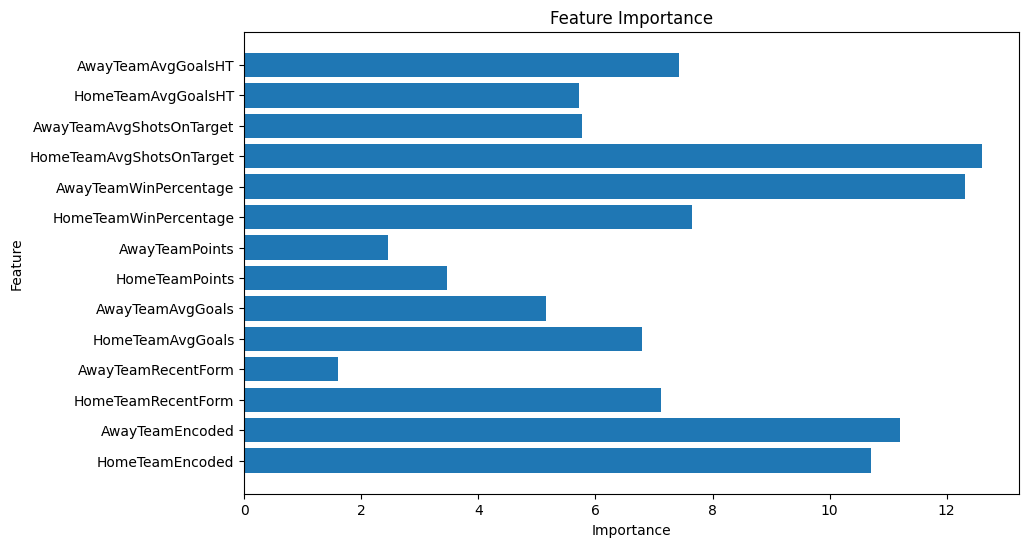

In [157]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = final_model.get_feature_importance()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [158]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, final_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsHT'].values[0]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = final_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = final_model.predict_proba(match_scaled)[0][2]
    draw_prob = final_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob


print('##########################')
print('Today\'s matches')

predict_match('Arsenal', 'Crystal Palace', final_model, scaler)





##########################
Today's matches
Arsenal win probability: 0.0009062855810323891
Crystal Palace win probability: 0.7988865858467289
Draw probability: 0.2002071285722387


(0.0009062855810323891, 0.7988865858467289, 0.2002071285722387)

In [159]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train_smote)

# Best Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.43      0.64      0.51        14
           D       0.20      0.20      0.20        10
           H       0.84      0.66      0.74        32

    accuracy                           0.57        56
   macro avg       0.49      0.50      0.48        56
weighted avg       0.62      0.57      0.59        56


In [160]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")


Average Cross-Validation Score: 0.5740740740740741


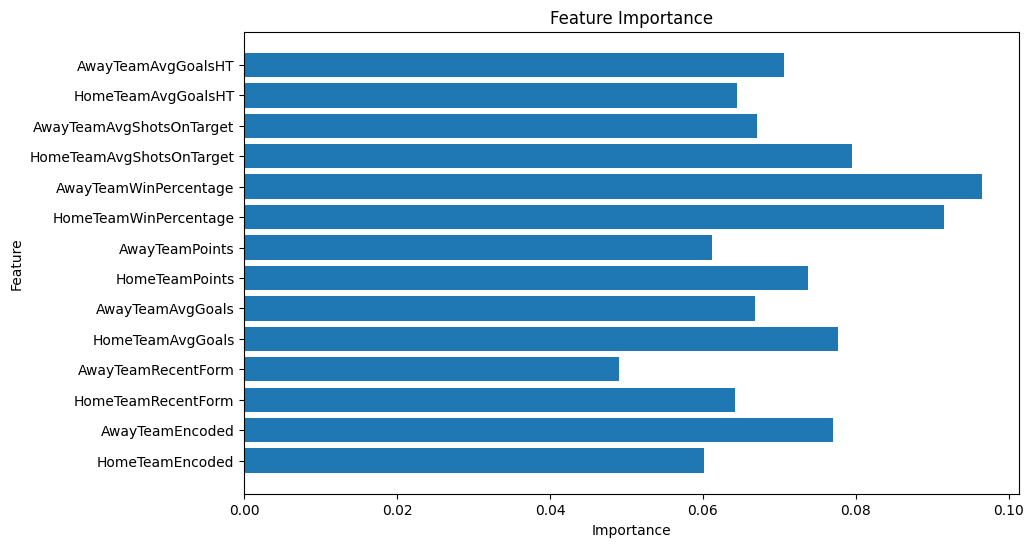

In [161]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [162]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, best_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsHT'].values[0]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = best_model.predict(match_scaled)[0][0]
    away_team_win_prob = best_model.predict(match_scaled)[0][2]
    draw_prob = best_model.predict(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob


print('##########################')
print('Today\'s matches')

predict_match('Arsenal', 'Crystal Palace', best_model, scaler)



##########################
Today's matches


IndexError: string index out of range

In [ ]:
from sklearn.metrics import roc_auc_score
# compare the two models
from sklearn.metrics import classification_report

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))

# Evaluate the model
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))




In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Select relevant columns or features
features = ['HomeTeam', 'AwayTeam', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT']
target = 'FTR'

# Create a comprehensive list of all teams
all_teams = sorted(list(set(df_cleaned['HomeTeam'].unique()) | set(df_cleaned['AwayTeam'].unique())))

# Fit the label encoder on this comprehensive list
team_encoder = LabelEncoder()
team_encoder.fit(all_teams)

# Encode team names
df_cleaned['HomeTeamEncoded'] = team_encoder.transform(df_cleaned['HomeTeam'])
df_cleaned['AwayTeamEncoded'] = team_encoder.transform(df_cleaned['AwayTeam'])

# Update features list to use encoded team names
features = ['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT']

# If the target variable is categorical, encode it separately
if df_cleaned[target].dtype == 'object':
    label_encoder = LabelEncoder()
    df_cleaned[target] = label_encoder.fit_transform(df_cleaned[target])

# Split the data into training and test sets
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# hyperparameter tuning for xgboost using hyperopt
from hyperopt import hp
import numpy as np
# Define the hyperparameter space

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'max_depth': hp.choice('max_depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 1, 10),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10)
    
}

In [ ]:
# Creating the Objective Function so that we can use it in the hyperparameter optimization

from hyperopt import STATUS_OK
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    clf = XGBClassifier(**params, objective='multi:softmax', num_class=3, eval_metric='mlogloss', verbosity=0)
    score = cross_val_score(clf, X_train_scaled, y_train_smote, scoring='accuracy', cv=StratifiedKFold(10)).mean()
    return {'loss': -score, 'status': STATUS_OK}



In [ ]:
# run the hyperparameter optimization
from hyperopt import tpe, Trials, fmin

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)



In [ ]:
from sklearn.metrics import classification_report

best_params = {k: int(v) if k in ['n_estimators', 'max_depth'] else v for k, v in best.items()}
best_model_2 = XGBClassifier(**best_params, objective='multi:softmax', num_class=3, eval_metric='mlogloss', verbosity=0)
best_model_2.fit(X_train_scaled, y_train_smote)


In [ ]:
# Evaluate the model
y_pred = best_model_2.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))

# check the auc score
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.2f' % auc)
      


In [ ]:
# get new predictions using the xgboost model
def predict_match(home_team, away_team, best_model_2, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT'])
    match.loc[0] = [team_encoder.transform([home_team])[0], team_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsHT'].values[0]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = best_model_2.predict_proba(match_scaled)[0][0]
    away_team_win_prob = best_model_2.predict_proba(match_scaled)[0][2]
    draw_prob = best_model_2.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob


predict_match('Arsenal', 'Crystal Palace', best_model_2, scaler)


In [ ]:
# import matplotlib.pyplot as plt
# 
# def plot_match_prediction(probabilities, match_title):
#     teams = ['Home Win', 'Away Win', 'Draw']
#     plt.figure(figsize=(10, 6))
#     plt.bar(teams, probabilities)
#     plt.xlabel('Outcome')
#     plt.ylabel('Probability')
#     plt.title(f'Predicted Match Outcome - {match_title}')
#     plt.ylim(0, 1)  # Set y-axis limit to 0-1 for probability
#     for i, prob in enumerate(probabilities):
#         plt.text(i, prob + 0.02, f'{prob:.2f}', ha='center')
#     plt.show()
# 
# # Brighton vs. Tottenham
# plot_match_prediction([0.2022, 0.3850, 0.4128], 'Brighton vs. Tottenham - XGBoost')
# plot_match_prediction([0.3364, 0.1976, 0.4661], 'Brighton vs. Tottenham - Random Forest')
# plot_match_prediction([0.1774, 0.0935, 0.7291], 'Brighton vs. Tottenham - CatBoost')
# 
# # Arsenal vs. West Ham
# plot_match_prediction([0.1326, 0.5867, 0.2807], 'Arsenal vs. West Ham - XGBoost')
# plot_match_prediction([0.1283, 0.5955, 0.2762], 'Arsenal vs. West Ham - Random Forest')
# plot_match_prediction([0.1060, 0.7360, 0.1580], 'Arsenal vs. West Ham - CatBoost')


In [ ]:
import shap

# Explain model's predictions using SHAP
explainer = shap.TreeExplainer(best_model_2)
shap_values = explainer.shap_values(X_test_scaled)

# Plot summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=features)


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming best_model_2 is your trained XGBoost model
# show features names
xgb.plot_importance(best_model_2, importance_type='gain')
plt.show()




In [ ]:
# making predictions for total goals in a game

#calculate recrent form in terms of goals scored
df_cleaned['HomeTeamRecentGoals'] = df_cleaned.groupby('HomeTeam')['FTHG'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)
df_cleaned['AwayTeamRecentGoals'] = df_cleaned.groupby('AwayTeam')['FTAG'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)

#calculate average goals scored
df_cleaned['HomeTeamAvgGoals'] = df_cleaned.groupby('HomeTeam')['FTHG'].transform('mean')
df_cleaned['AwayTeamAvgGoals'] = df_cleaned.groupby('AwayTeam')['FTAG'].transform('mean')

#calculate average goals conceded
df_cleaned['HomeTeamAvgGoalsConceded'] = df_cleaned.groupby('HomeTeam')['FTAG'].transform('mean')
df_cleaned['AwayTeamAvgGoalsConceded'] = df_cleaned.groupby('AwayTeam')['FTHG'].transform('mean')



In [ ]:
# select relevant columns or features
features = ['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget','HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamAvgGoalsConceded', 'AwayTeamAvgGoalsConceded', 'HomeTeamRecentGoals', 'AwayTeamRecentGoals']
x = df_cleaned[features]

# target variables for total goals in a game
y = df_cleaned['FTHG'] + df_cleaned['FTAG']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
# Hyperparameter Tuning
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)


In [ ]:
# make predictions
predicted_goals = model.predict(X_test_scaled)

# determine over/under 1.5 goals
over_under_1_5 = ['Over 1.5' if goals > 1.5 else 'Under 1.5' for goals in predicted_goals]

